In [2]:
import os
import pandas as pd
import numpy as np
import itertools

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-darkgrid')
large = 22; med = 15; small = 13
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': small,
          'axes.titlesize': small,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

In [3]:
os.listdir('/Users/harrison/datasets/Purchase Redemption Data')

['EDA.ipynb',
 '.DS_Store',
 'mfd_day_share_interest.csv',
 'comp_predict_table.csv',
 'ipynb',
 'readme.md',
 'user_balance_table.csv',
 'result.csv',
 '.ipynb_checkpoints',
 'mfd_bank_shibor.csv',
 'user_profile_table.csv']

In [4]:
def read_file(fname):
    df = pd.read_csv(fname)
    print(df.shape)
    return df

In [5]:
u_bal = read_file('/Users/harrison/datasets/Purchase Redemption Data/user_balance_table.csv')
u_bal.head()

(2840421, 18)


,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,20140811,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,20140814,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,20140817,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


# 目标数据

In [6]:
all_data = u_bal.groupby('report_date').sum()[['total_purchase_amt','total_redeem_amt']]
all_data.index = pd.date_range(start='2013-07-01',end='2014-08-31')
all_data.columns = ['pur','red']
all_data.head()

,pur,red
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587


# 周期规律

<AxesSubplot:>

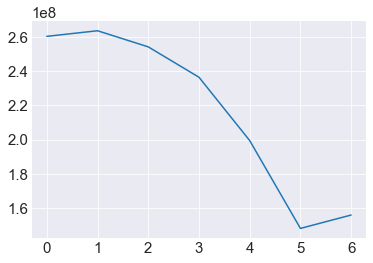

In [7]:
all_data.groupby([all_data.index.weekday]).pur.mean().plot()

In [9]:
# 周
all_data['weekday'] = all_data.index.weekday

# 过滤数据

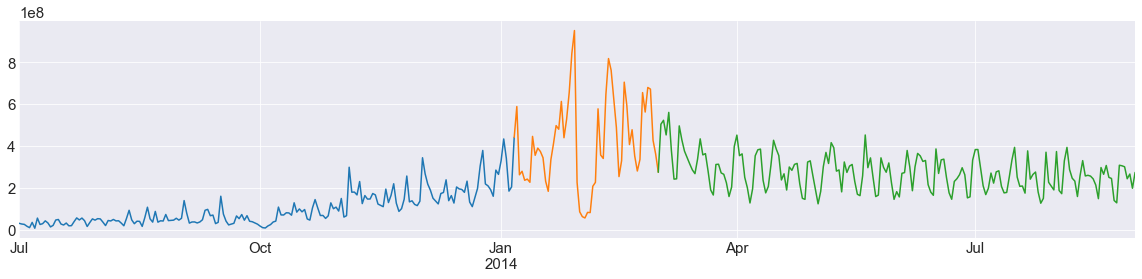

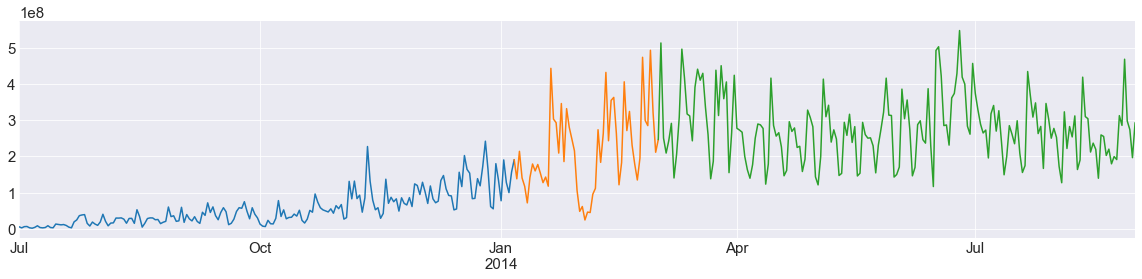

In [10]:
remove_s = '2014-01-06'
reomve_e = '2014-03-02'

adj_range = [all_data[:remove_s], all_data[remove_s:reomve_e], all_data[reomve_e:]]
for i in adj_range:
    i.pur.plot(figsize=(20,4))
plt.show()
for i in adj_range:
    i.red.plot(figsize=(20,4))

In [11]:
adj_data = pd.concat([all_data[:'2014-01-05'], all_data['2014-03-03':]], ignore_index=True)
adj_data.index = pd.date_range(periods=len(adj_data),end='2014-08-31')

# 评价函数

In [12]:
def AE(y, yhat):
    return np.abs(y - yhat) / np.abs(y)

def total_AE(purchasehat, redeemhat, purchase, redeem, h: int = 0.1):
    return sum(map(lambda x : np.exp(-x/h)*10, AE(purchase, purchasehat))) * 0.45 + sum(map(lambda x : np.exp(-x/h)*10, AE(redeem, redeemhat))) * 0.55

In [13]:
def acf_pacf(df,size=(18,6)):
    df = df.dropna()
    fig, axes = plt.subplots(1, 2, figsize=size)
    plot_acf(df,lags=40, ax=axes[0])

    plot_pacf(df,lags=40, ax=axes[1])
    plt.show()

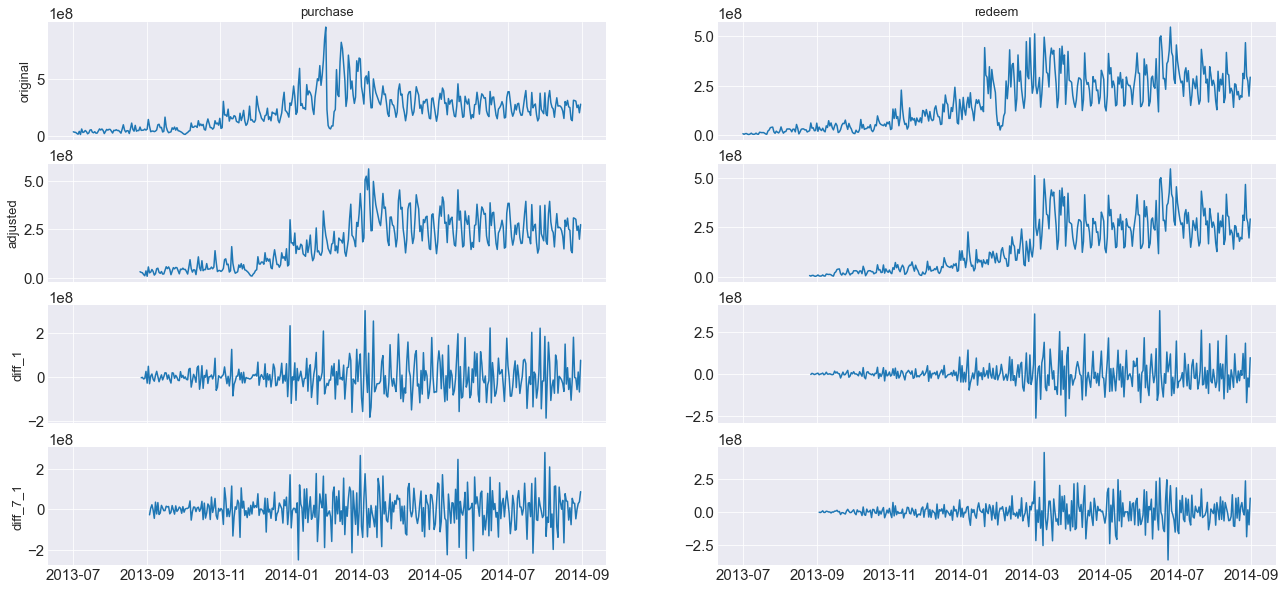

In [14]:
fig, axes = plt.subplots(4, 2, figsize=(22,10), sharex=True)
axes[0][0].set_ylabel('original')
axes[0][0].set_title('purchase')
axes[0][0].plot(all_data.pur)
axes[0][1].set_title('redeem')
axes[0][1].plot(all_data.red)

axes[1][0].set_ylabel('adjusted')
axes[1][0].plot(adj_data.pur)
axes[1][1].plot(adj_data.red)

axes[2][0].set_ylabel('diff_1')
axes[2][0].plot(adj_data.pur.diff(1))
axes[2][1].plot(adj_data.red.diff(1))

axes[3][0].set_ylabel('diff_7_1')
axes[3][0].plot(adj_data.pur.diff(7).diff(1))
axes[3][1].plot(adj_data.red.diff(7).diff(1))

fig.show()

# 季节波动

<Figure size 432x288 with 0 Axes>

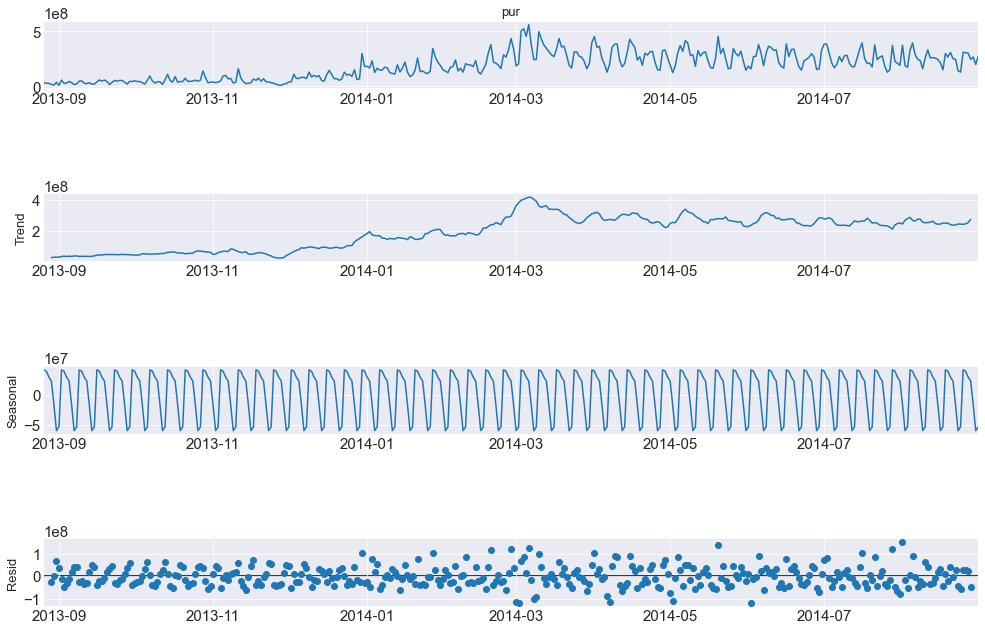

In [40]:
de_season = seasonal_decompose(adj_data.pur, model='addictive')
fig = plt.figure()
fig = de_season.plot()
fig.set_size_inches(15,10)

<AxesSubplot:>

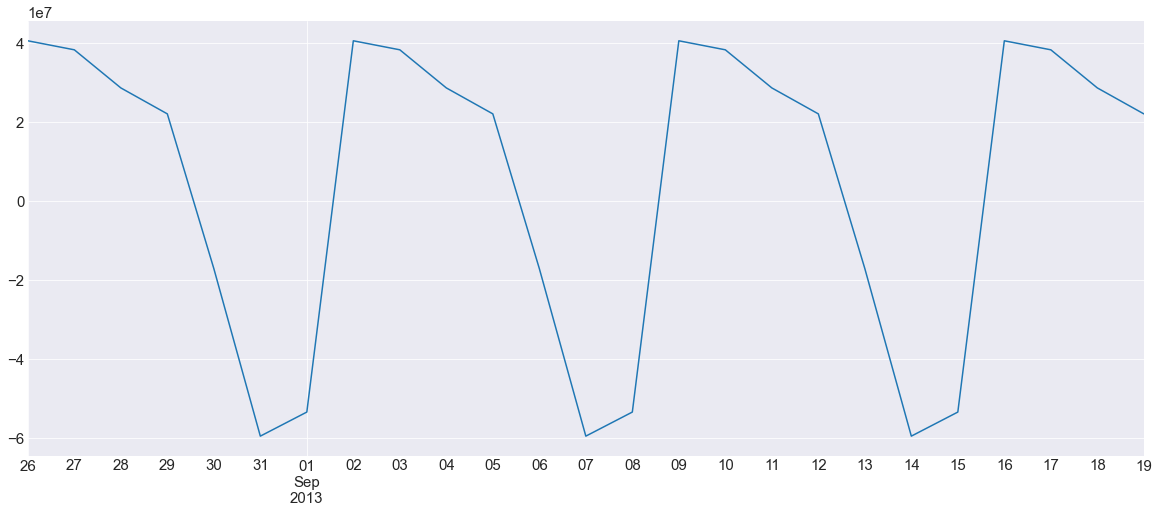

In [46]:
de_season.seasonal[:25].plot(figsize=(20,8))

# 平稳测试

In [645]:
adfuller(adj_data.pur.diff(7).diff(1).dropna())

(-8.014034285860644,
 2.162859572749436e-12,
 14,
 348,
 {'1%': -3.4492815848836296,
  '5%': -2.8698813715275406,
  '10%': -2.5712138845950587},
 13320.150746838603)

In [17]:
# 平稳性测试 redeem
adfuller(adj_data.red.diff(7).diff(1).dropna())

(-8.566486494100229,
 8.419397138055534e-14,
 13,
 349,
 {'1%': -3.449226932880019,
  '5%': -2.869857365438656,
  '10%': -2.571201085130664},
 13365.908583417728)

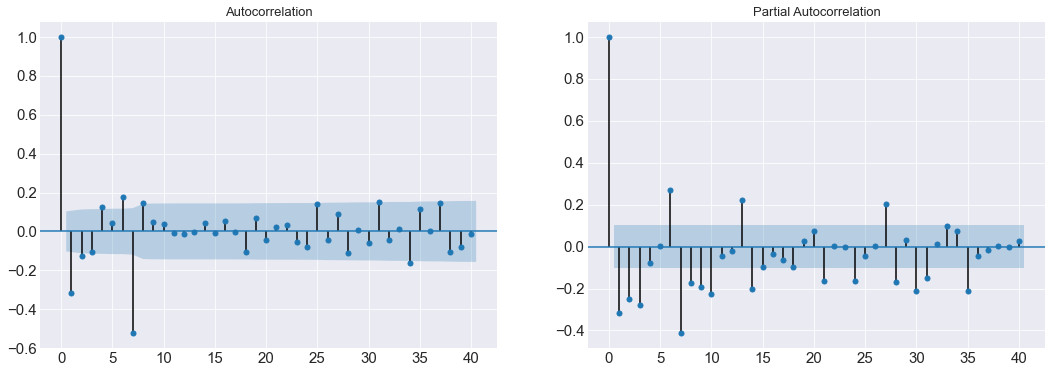

In [18]:
# purchase
pur_d = adj_data.pur.diff(7).diff(1)
acf_pacf(pur_d)

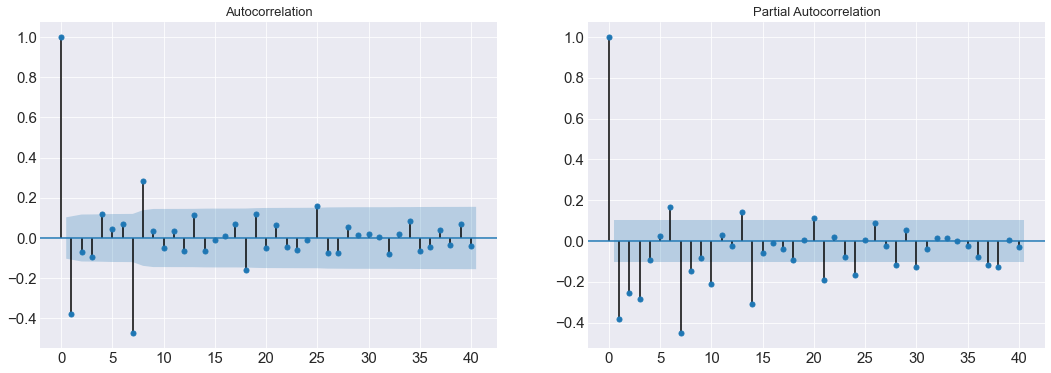

In [19]:
# redeem
red_d = adj_data.red.diff(7).diff(1)
acf_pacf(red_d)

# p, q 调参

In [25]:
# pur ARMA(p,q)
purResDiff = arma_order_select_ic(adj_data.pur.diff(7).diff(1).dropna(), max_ar=6, max_ma=6, ic=['aic'], trend='nc')
print('ARMA(p,q) = {aic} is the best.'.format(aic=purResDiff['aic_min_order']))

ARMA(p,q) = (6, 5) is the best.


In [26]:
# red ARMA(p,q)
redResDiff = arma_order_select_ic(adj_data.red.diff(7).diff(1).dropna(), max_ar=6, max_ma=6, ic=['aic'], trend='nc')
print('ARMA(p,q) = {aic} is the best.'.format(aic=purResDiff['aic_min_order']))

ARMA(p,q) = (6, 5) is the best.


In [28]:
start_tr = 0
split = len(adj_data)-30
test_end = split + 30

def sarimax_mod(data, trend, order, seasonal_order,
                start_tr=start_tr,
                split=split,
                test_end=test_end):
    train = data[start_tr:split]
    test = data[split:test_end]

    mod = SARIMAX(train, trend=trend, order=order, seasonal_order=seasonal_order).fit()
    pre = mod.predict(start=split, end=test_end-1, dynamic=False)

    return mod, pre, test
    
def pur_AE(pre_pur, pur, h: int = 0.08):
    return sum(map(lambda x : np.exp(-x/h)*10, AE(pur, pre_pur))) * 0.45

def red_AE(pre_red, red, h: int = 0.08):
    return sum(map(lambda x : np.exp(-x/h)*10, AE(red, pre_red))) * 0.55

# 季节因素调参

In [36]:
# purchase
p = q = range(0, 7)
PDQs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, range(1, 2), q))]
a = []
b = []
aic = pd.DataFrame()
for s_param in PDQs:
    try:
        pur_mod, pre_pur, pur_test = sarimax_mod(data=adj_data.pur,
                          trend='c', order=(6,1,5), seasonal_order=s_param)
        print('PDQs{} - AIC:{}'.format(s_param, pur_mod.aic))
        a.append(s_param)
        b.append(pur_mod.aic)
    except:
        continue
aic['PDQs']=a
aic['aic']=b
aic[aic['aic'] == aic['aic'].min()]

PDQs(0, 1, 0, 7) - AIC:12890.01091205073
PDQs(0, 1, 1, 7) - AIC:12835.384752703818
PDQs(0, 1, 2, 7) - AIC:12837.348226066404
PDQs(0, 1, 3, 7) - AIC:12838.034424312114
PDQs(0, 1, 4, 7) - AIC:12834.735203408309
PDQs(0, 1, 5, 7) - AIC:12838.640249901096
PDQs(0, 1, 6, 7) - AIC:12840.435467528094
PDQs(1, 1, 0, 7) - AIC:12847.253526817682
PDQs(1, 1, 1, 7) - AIC:12832.818193398467
PDQs(1, 1, 2, 7) - AIC:12834.290221083604
PDQs(1, 1, 3, 7) - AIC:12838.656887848905
PDQs(1, 1, 4, 7) - AIC:12838.694265935213
PDQs(1, 1, 5, 7) - AIC:12838.044709181224
PDQs(1, 1, 6, 7) - AIC:12839.279914874267
PDQs(2, 1, 0, 7) - AIC:12845.201126040347
PDQs(2, 1, 1, 7) - AIC:12835.352793285725
PDQs(2, 1, 2, 7) - AIC:12837.708021978986
PDQs(2, 1, 3, 7) - AIC:12837.686120094513
PDQs(2, 1, 4, 7) - AIC:12839.597898454147
PDQs(2, 1, 5, 7) - AIC:12841.977558669798
PDQs(2, 1, 6, 7) - AIC:12840.116772402042
PDQs(3, 1, 0, 7) - AIC:12845.126385980513
PDQs(3, 1, 1, 7) - AIC:12835.333184072639
PDQs(3, 1, 2, 7) - AIC:12836.462293

,PDQs,aic
8,"(1, 1, 1, 7)",12832.818193


In [ ]:
# redeem
p = q = range(0, 7)
PDQs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, range(1, 2), q))]
a = []
b = []
aic = pd.DataFrame()
for s_param in PDQs:
    try:
        red_mod, pre_red, red_test = sarimax_mod(data=adj_data.red,
                          trend='n', order=(6,1,5), seasonal_order=s_param)
        print('PDQs{} - AIC:{}'.format(s_param, red_mod.aic))
        a.append(s_param)
        b.append(red_mod.aic)
    except:
        continue
aic['PDQs']=a
aic['aic']=b
aic[aic['aic'] == aic['aic'].min()]

In [30]:
pur_comb = {}

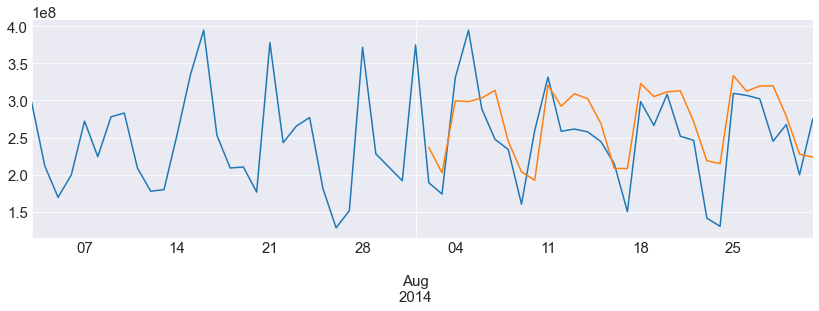

36.21083461150092
------------------------------------------------------------------------------------------------------------------------


In [37]:
pur_mod, pre_pur, pur_test = sarimax_mod(data=adj_data.pur,
                                trend='c', order=(6,1,5), seasonal_order=(1,1,1,7))

fig = plt.figure(figsize=(14,4))
adj_data[-60:].pur.plot()
pre_pur.plot()
plt.show()

result = pur_AE(pre_pur, pur_test)
model_name = pur_mod.summary().tables[0].data[1][1]
pur_comb[model_name] = result
print(result)
print('-'*120)

In [35]:
pd.DataFrame(pur_comb, index=['score']).T.reset_index().sort_values('score',ascending=False).head(10)

,index,score
0,"SARIMAX(6, 1, 5)x(0, 1, [1], 7)",45.801467


___

In [32]:
red_comb = {}

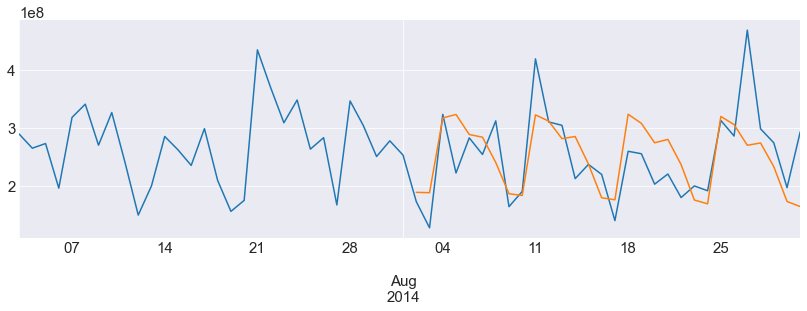

44.21749329648563
------------------------------------------------------------------------------------------------------------------------


In [33]:
# redeem
red_mod, pre_red, red_test = sarimax_mod(data=adj_data.red, 
                                trend='n', order=(6,1,5), seasonal_order=(0,1,1,7))

fig = plt.figure(figsize=(14,4))
adj_data[-60:].red.plot()
pre_red.plot()
plt.show()

result = red_AE(pre_red, red_test)
model_name = red_mod.summary().tables[0].data[1][1]
red_comb[model_name] = result
print(result)
print('-'*120)

In [34]:
pd.DataFrame(red_comb, index=['score']).T.reset_index().sort_values('score',ascending=False)

,index,score
0,"SARIMAX(6, 1, 5)x(0, 1, [1], 7)",44.217493


In [ ]:
pur_mod.plot_diagnostics(figsize=(12,12))
pur_mod.summary()

In [ ]:
red_mod.plot_diagnostics(figsize=(12,12))
red_mod.summary()

# 最终模型

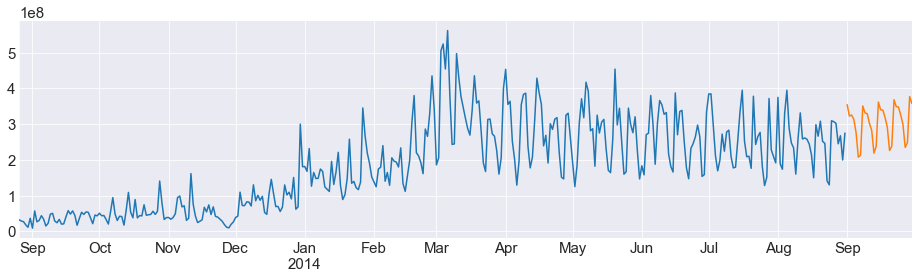

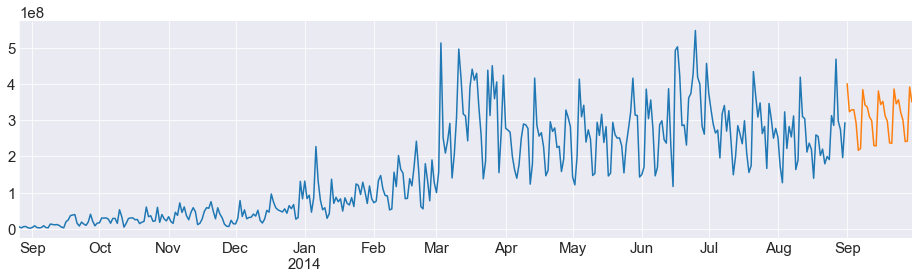

In [38]:
start_tr = 0
split = len(adj_data)
test_end = split + 30

train = adj_data[start_tr:split]
test = adj_data[split:test_end]

pur_mod = SARIMAX(train.pur, trend='c', order=(6,1,5), seasonal_order=(0,1,1,7)).fit()
pre_pur = pur_mod.predict(start=split, end=test_end-1, dynamic=False)


red_mod = SARIMAX(train.red, trend='n', order=(6,1,5), seasonal_order=(0,1,1,7)).fit()
pre_red = red_mod.predict(start=split, end=test_end-1, dynamic=False)


fig = plt.figure(figsize=(16,4))
adj_data.pur.plot()
pre_pur.plot()
plt.show()

fig = plt.figure(figsize=(16,4))
adj_data.red.plot()
pre_red.plot()
plt.show()

# 结果

In [39]:
# result dataframe
result = pd.DataFrame(index = range(20140901,20140931))
result['pre_pur'] = pre_pur.values.astype('int')
result['pre_red'] = pre_red.values.astype('int')
result.to_csv('result.csv',header=False)

In [21]:
result.tail()

,pre_pur,pre_red
20140926,316769593,321828833
20140927,234661882,267670562
20140928,235675931,266772102
20140929,371761055,412629001
20140930,358220963,374732156
